In [1]:
print(__doc__)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

Automatically created module for IPython interactive environment


## Load dataset

Load data from local directory

The data is downloaded from kaggle dataset: 
https://www.kaggle.com/nareshbhat/health-care-data-set-on-heart-attack-possibility?select=heart.csv

And it contains following 14 fields

1. age
2. sex
3. chest pain type (4 values)
4. resting blood pressure
5. serum cholestoral in mg/dl
6. fasting blood sugar > 120 mg/dl
7. resting electrocardiographic results (values 0,1,2)
8. maximum heart rate achieved
9. exercise induced angina
10. oldpeak = ST depression induced by exercise relative to rest
11. the slope of the peak exercise ST segment
12. number of major vessels (0-3) colored by flourosopy
13. thal: 0 = normal; 1 = fixed defect; 2 = reversable defect
14. target: 0= less chance of heart attack 1= more chance of heart attack

In [2]:
df = pd.read_csv("/Users/zruxi/explainit/data/data.csv")
df.head(2)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1


In [3]:
x_feats = df.columns.tolist()[:-1]

X = df[x_feats]
y = df['target']

## Create a radom dategorical feature and a random numerical feature

In [4]:
rng = np.random.RandomState(seed=42)
X['random_cat'] = rng.randint(3, size=X.shape[0])
X['random_num'] = rng.randn(X.shape[0])

categorical_columns = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'random_cat']
numerical_columns = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'random_num']

X = X[categorical_columns + numerical_columns]

## Split data into train and test sets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)

## Fit and predict via RandomForestClassifier

In [6]:
clf = RandomForestClassifier(random_state=0, n_jobs=-1)

clf = clf.fit(X_train, y_train)

y_pred=clf.predict(X_train)
prob=clf.predict_proba(X_test)

## Inference with SKATER -- Global Interpretations

In [10]:

from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

from skater.core.global_interpretation.tree_surrogate import TreeSurrogate
from skater.util.dataops import show_in_notebook

interpreter = Interpretation(
        training_data=X_train, training_labels=y_train, 
    feature_names=categorical_columns + numerical_columns
    )

pyint_model = InMemoryModel(
            clf.predict_proba,
            examples=X_train,
            target_names='target',
            unique_values=np.unique(y_train).tolist(),
            feature_names=categorical_columns + numerical_columns,
        )

## Feature Importance


2020-07-07 20:32:00,546 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False
2020-07-07 20:32:00,650 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[15/15] features ████████████████████ Time elapsed: 2 seconds

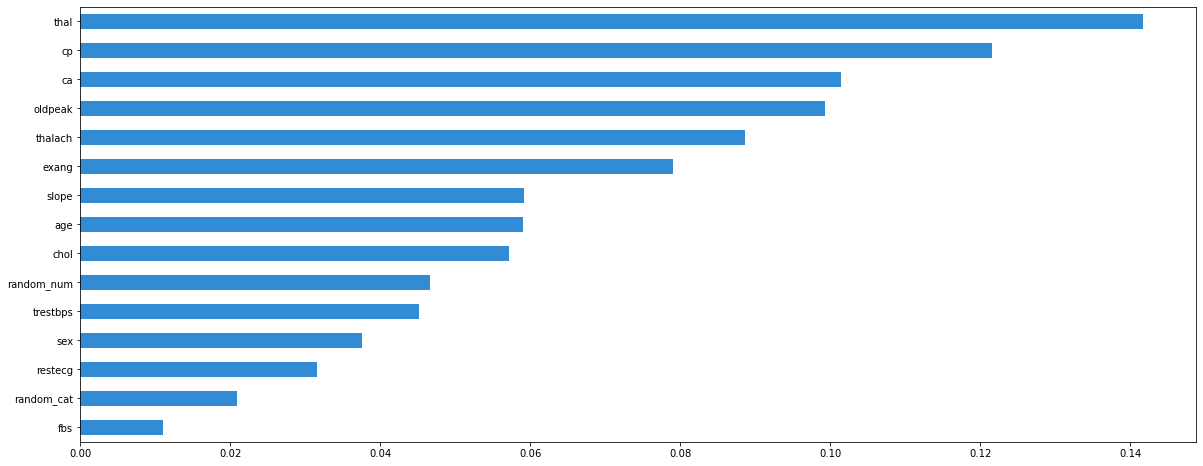

In [11]:
plots = interpreter.feature_importance.plot_feature_importance(pyint_model, ascending=True, progressbar=True,
                                n_jobs=-1)

## Surrogate tree

2020-07-07 20:51:59,701 - skater.core.global_interpretation.tree_surrogate - INFO - post pruning applied ...
2020-07-07 20:51:59,708 - skater.core.global_interpretation.tree_surrogate - INFO - Scorer used cross-entropy
2020-07-07 20:51:59,710 - skater.core.global_interpretation.tree_surrogate - INFO - original score using base model 0.3548380791139221
2020-07-07 20:51:59,729 - skater.core.global_interpretation.tree_surrogate - INFO - Summary: childrens of the following nodes are removed []
2020-07-07 20:51:59,731 - skater.core.global_interpretation.tree_surrogate - INFO - Done generating prediction using the surrogate, shape (227, 2)
2020-07-07 20:51:59,736 - skater.core.global_interpretation.tree_surrogate - INFO - Done scoring, surrogate score 0.355; oracle score 0.112


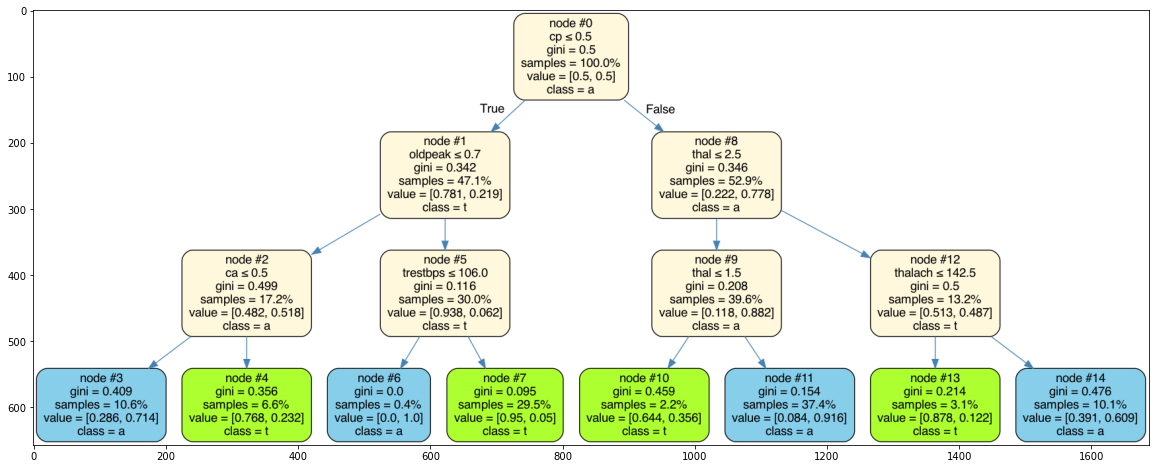

In [21]:
surrogate_explainer = interpreter.tree_surrogate(oracle=pyint_model, seed=5, max_depth=3)
surrogate_explainer.fit(X_train, y_train)
surrogate_explainer.plot_global_decisions(show_img=True)

In [22]:
surrogate_explainer.decisions_as_txt()

if cp <= 0.5 {
  if oldpeak <= 0.7000000178813934 {
    if ca <= 0.5 {
        Predicted Label: 1
    } else {
        Predicted Label: 0
    }
  } else {
    if trestbps <= 106.0 {
        Predicted Label: 1
    } else {
        Predicted Label: 0
    }
  }
} else {
  if thal <= 2.5 {
    if thal <= 1.5 {
        Predicted Label: 0
    } else {
        Predicted Label: 1
    }
  } else {
    if thalach <= 142.5 {
        Predicted Label: 0
    } else {
        Predicted Label: 1
    }
  }
}


## Understanding interaction

2020-07-07 21:21:20,719 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False
2020-07-07 21:21:20,726 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[40/40] grid cells ████████████████████ Time elapsed: 7 seconds

[[<Figure size 1152x720 with 2 Axes>,

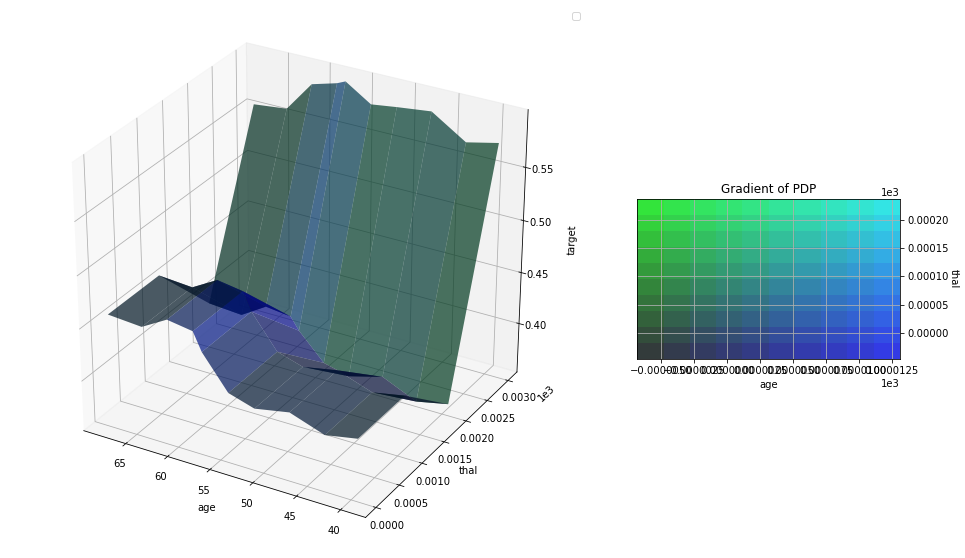

In [51]:
model = InMemoryModel(clf.predict_proba, examples=X_train, target_names=['target'])
interpreter.partial_dependence.plot_partial_dependence([('age', 'thal')], model, 
                                                       grid_resolution=10)